In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

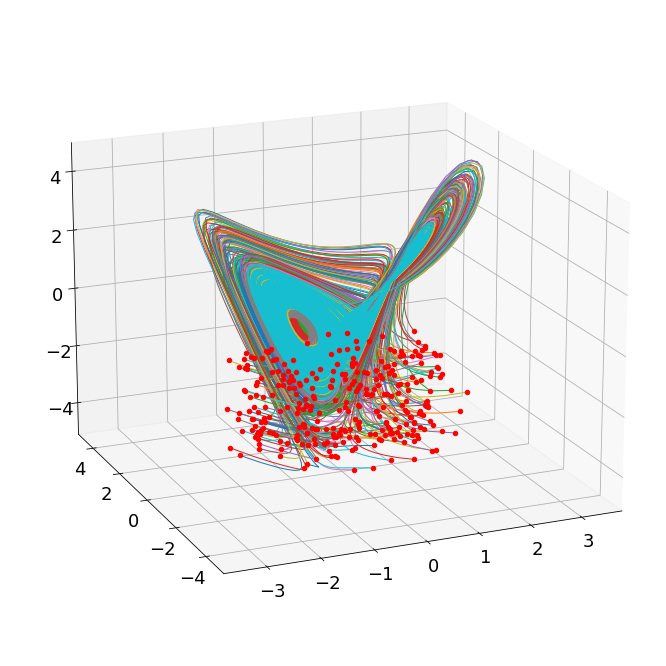

In [2]:
## Simulate the Lorenz System

dt = 0.01
T = 200
t = np.arange(0,T+dt,dt)
beta = 8/3
sigma = 10
rho = 28


nn_input = np.zeros((300*(len(t)-1),3))
nn_output = np.zeros_like(nn_input)

fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})


def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
x0 = -15 + 30 * np.random.random((300, 3))

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])

for j in range(300):
    # nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
    # nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]
    x, y, z = x_t[j,:,:].T
    x = (x-np.mean(x))/np.std(x)
    y = (y-np.mean(y))/np.std(y)
    z = (z - np.mean(z))/np.std(z)
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = (np.array([x[:-1],y[:-1],z[:-1]])).T
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = (np.array([x[1:],y[1:],z[1:]])).T
    ax.plot(x, y, z,linewidth=1)
    #ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
    ax.scatter(x[0],y[0],z[0],color='r')

# nn_input = (nn_input - np.mean(nn_input))/(np.std(nn_input))
# nn_output = (nn_output - np.mean(nn_output))/(np.std(nn_output))
             
ax.view_init(18, -113)
plt.show()

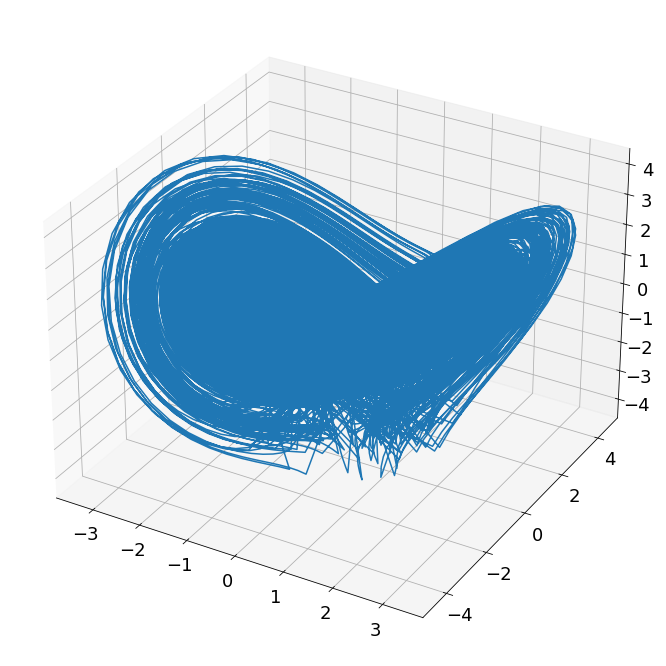

In [3]:
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
ax.plot(nn_output[:,0], nn_output[:,1], nn_output[:,2])
plt.show()

In [4]:
nn_input.shape

(6000000, 3)

In [5]:
## NN

import torch
from torch import nn
from torch import optim

# def model(nn.Module):
#     __init__(gpu)

model = nn.Sequential(nn.Linear(3, 10),
                    nn.ReLU(),
                    nn.Linear(10, 10),
                    nn.ReLU(),
                    nn.Linear(10, 10),
                    nn.ReLU(),
                    nn.Linear(10,3),
                    )

#model.to(device=torch.device('cuda:4'))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [6]:
nn_input[1] - nn_output[0]

array([0., 0., 0.])

In [7]:
nn_input = torch.from_numpy(nn_input.astype(np.float64))
nn_output = torch.from_numpy(nn_output.astype(np.float64))

epochs = 10000
model.train()
#batch_size = 1000
for e in range(epochs):
    running_loss = 0
#    for i in range(int(nn_input.shape[0]/batch_size)):
    optimizer.zero_grad()
    output = model(nn_input.float())

    loss = criterion(output, nn_output.float())
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    #running_loss /= nn_input.shape[0]/batch_size
    if not(e%200):
        print(f"Training loss: {running_loss}")

Training loss: 1.00919771194458
Training loss: 0.04175950586795807
Training loss: 0.018921149894595146
Training loss: 0.010825755074620247
Training loss: 0.0065617989748716354
Training loss: 0.003722510300576687
Training loss: 0.002287491224706173
Training loss: 0.0016822941834107041
Training loss: 0.001364824827760458
Training loss: 0.0011538831749930978
Training loss: 0.0009943264303728938
Training loss: 0.0008665862842462957
Training loss: 0.0007688460173085332
Training loss: 0.000699544558301568
Training loss: 0.0006482679746113718
Training loss: 0.0006081434548832476
Training loss: 0.0005747980321757495
Training loss: 0.000545204384252429
Training loss: 0.0005070005427114666
Training loss: 0.0004796139255631715
Training loss: 0.0004552957252599299
Training loss: 0.0004326014022808522
Training loss: 0.0004109822621103376
Training loss: 0.0003903362376149744
Training loss: 0.00037010308005847037
Training loss: 0.00034979439806193113
Training loss: 0.0003291616740170866
Training loss

In [8]:
# for e in range(5000):
#     running_loss = 0
# #    for i in range(int(nn_input.shape[0]/batch_size)):
#     optimizer.zero_grad()
#     output = model(nn_input.float())

#     loss = criterion(output, nn_output.float())
#     loss.backward()
#     optimizer.step()

#     running_loss += loss.item()
#     #running_loss /= nn_input.shape[0]/batch_size
#     if not(e%100):
#         print(f"Training loss: {running_loss}")

In [60]:
np.mean(x_t,axis=(0,1))


array([-0.06729334, -0.06751506, 23.64320793])

In [76]:
y_nn = torch.zeros((len(t),300,3))
#x0 = torch.from_numpy((np.asarray(x0) - np.mean(x_t,axis=(1)))/np.std(x_t,(1))) 
x0 = torch.from_numpy((x_t[:,0,:]-np.mean(x_t,axis=(1)))/np.std(x_t,(1)))

In [77]:
y_nn[0,:,:] = x0
#model.to(device='cpu')
model.eval()
with torch.no_grad():
    for j in range(len(t)-1):
        y0 = model(x0.float())
        y_nn[j+1,:,:] = y0
        #y_nn=np.append(y_nn,y0)
        x0 = y0

In [78]:
np.mean(x_t,axis=(1)).shape

(300, 3)

In [96]:
(y_nn[0,1,:] - (x_t[1,0,:]-np.mean(x_t,axis=(1)))/np.std(x_t,(1))).shape

torch.Size([300, 3])

In [98]:
(y_nn[0,1,:]).shape

(3,)

[]

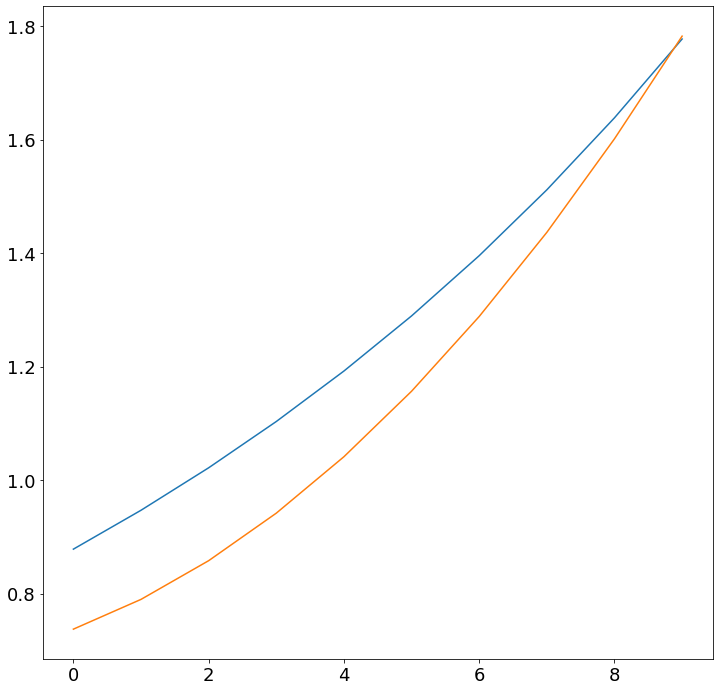

In [92]:
plt.plot(y_nn[0:10,1,1].detach().numpy())
plt.plot((x_t[1,0:10,1]-np.mean(x_t[:,:,1],axis=(0,1)))/np.std(x_t[:,:,1],(0,1)))
plt.plot()

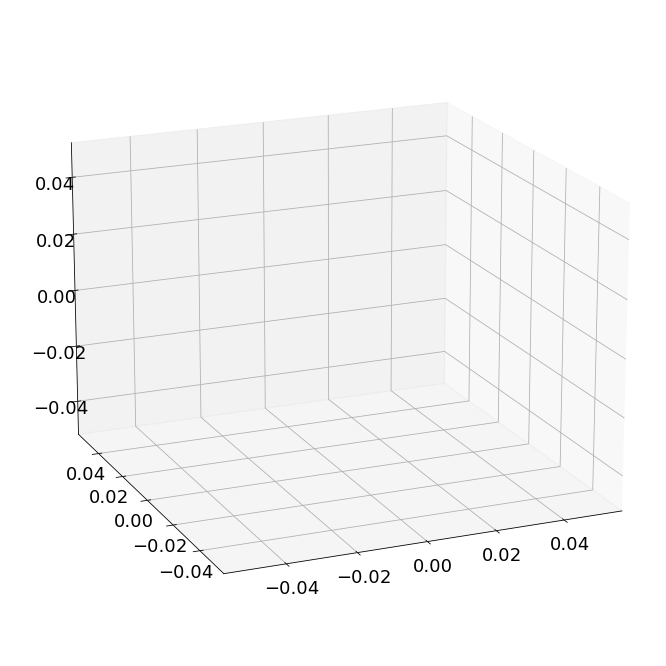

In [72]:
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})

# x, y, z = (y_nn[:,1,:].T).detach().numpy()
# ax.scatter(x, y, z,linewidth=1)
    #ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')

for j in range(100):

    x, y, z = (y_nn[:,j,:].T).detach().numpy()#*np.std(x_t,(0,1)) + np.mean(x_t,axis=(0,1))
    ax.plot(x, y, z,linewidth=1)
    #ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
    
             
ax.view_init(18, -113)
plt.show()

In [14]:

# fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
# np.random.seed(1)
# x0 = -15 + 30 * np.random.random((100, 3))

# x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
#                   for x0_j in x0])

# for j in range(100):

#     x, y, z = x_t[j,:,:].T
#     ax.plot(x, y, z,linewidth=1)
#     ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
             
# ax.view_init(18, -113)
# plt.show()

In [15]:
# y_nn = torch.zeros((len(t),100,3))
# x0 = torch.from_numpy(np.asarray(x0 - np.mean(x_t,axis=(0,1)))/np.std(x_t,(0,1))) 
# y_nn[0,:,:] = x0
# for j in range(len(t)-1):
#     y0 = model(x0.float())
#     y_nn[j+1,:,:] = y0
#     #y_nn=np.append(y_nn,y0)
#     x0 = y0

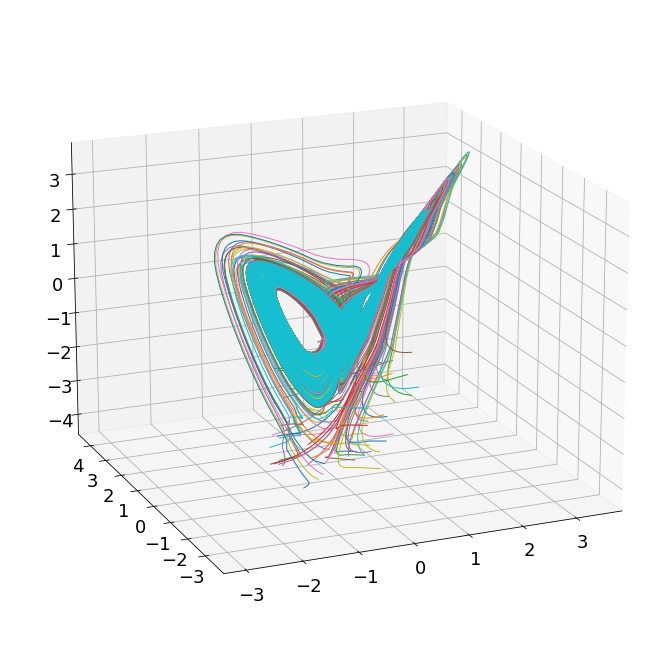

In [16]:
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})

for j in range(100):

    x, y, z = ((y_nn[:,j,:]).T).detach().numpy() #*np.std(x_t,(0,1)) + np.mean(x_t,axis=(0,1))
    ax.plot(x, y, z,linewidth=1)
    #ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
    
             
ax.view_init(18, -113)
plt.show()

#(y_nn[:,j,:]).detach().numpy()

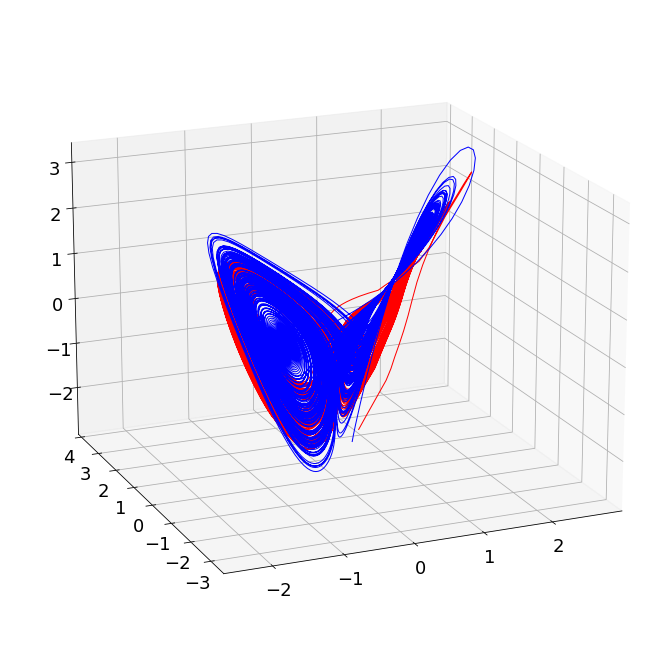

In [27]:
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})

j=19

x, y, z = ((y_nn[:,j,:]).T).detach().numpy() #*np.std(x_t,(0,1)) + np.mean(x_t,axis=(0,1))
ax.plot(x, y, z,linewidth=1, color='r')
#ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
x1, y1, z1 = (((x_t[j,:,:]) - np.mean(x_t[:,:,:],axis = (0,1)))/np.std(x_t[:,:,:],(0,1))[0]).T
ax.plot(x1, y1, z1,linewidth=1, color='b')
    
             
ax.view_init(18, -113)
plt.show()

In [18]:
dls = np.zeros(100)
for i in range(len(t)-1):
    for j in np.where(dls == 0)[0]:
        #print(j)
        if np.sum((y_nn[j,i,:].detach().numpy() - (x_t[j,i,:] - np.mean(x_t[:,i,:],axis = (0,1)))/np.std(x_t[:,i,:],(0,1)))**2) > 5:
            #print(np.sum((y0[j,:].detach().numpy() - (x_t_test[j,i,:] - np.mean(x_t_test[:,i,:],axis = (0,1)))/np.std(x_t_test[:,i,:],(0,1)))**2))
            dls[j] = (i+1)*dt

print(np.mean(dls))

0.017


[]

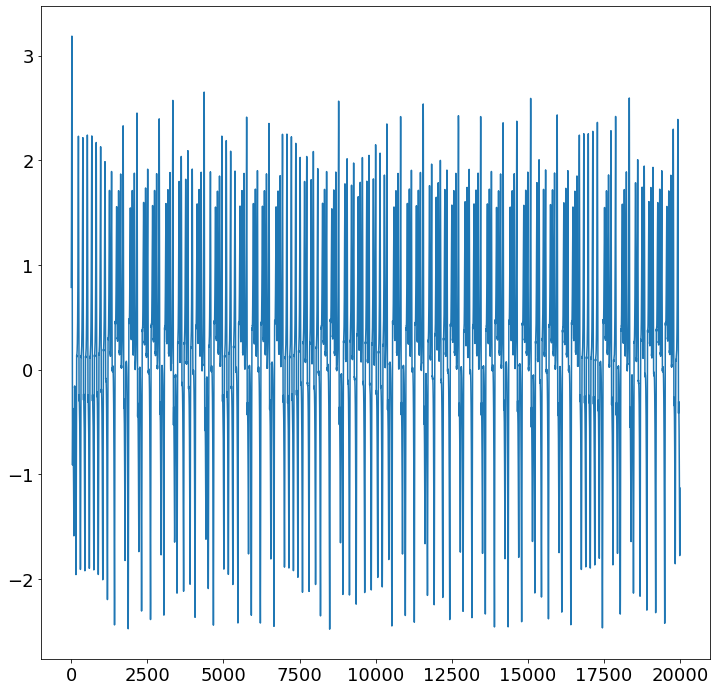

In [19]:
plt.plot(y_nn[:,1,1].detach().numpy())
plt.plot()

In [20]:
x0_test = -15 + 30 * np.random.random((100, 3))
x_t_test = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t) for x0_j in x0_test])
x_t_test_n = (x_t_test - np.mean(x_t_test,axis=(0,1)))/np.std(x_t_test,(0,1))
## predict on normalized testing data
y_pred = torch.zeros((len(t),100,3))
x0_test_n = torch.from_numpy(x_t_test_n[:,0,:])#(np.asarray(x0_test - np.mean(x_t_test,axis=(0,1)))/np.std(x_t_test,(0,1)))
y_pred[0,:,:] = x0_test_n#.float()
#print(y_pred[0,:,:] - x0_test_n)
dls = np.zeros(100)
with torch.no_grad():
    for i in range(len(t)-1):
        y0 = model.forward(y_pred[i,:,:])
        y_pred[i+1,:,:] = y0
        #x0_test_n = y0
        for j in np.where(dls == 0)[0]:
            #print(j)
            if np.sum((y0[j,:].detach().numpy() - x_t_test_n[:,i+1,:])**2) > 5:
            #(x_t_test[j,i+1,:] - np.mean(x_t_test[:,i+1,:],axis = (0,1)))/np.std(x_t_test[:,i+1,:],(0,1)))**2) > 5:
                #print(np.sum((y0[j,:].detach().numpy() - (x_t_test[j,i,:] - np.mean(x_t_test[:,i,:],axis = (0,1)))/np.std(x_t_test[:,i,:],(0,1)))**2))
                dls[j] = (i+1)*dt

# print("Printing again!!!!!")
# print(y_pred[0,:,:] - x0_test_n)
print(np.mean(dls))

0.009999999999999998


In [21]:
dls

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01])

In [22]:
(y0[j,:].detach().numpy() - (x_t_test[j,i,:] - np.mean(x_t_test[:,i,:],axis = (0,1)))/np.std(x_t_test[:,i,:],(0,1)))

array([ 0.53944181,  1.08392298, -2.156578  ])

In [23]:
(y0[j,:].detach().numpy() - (x_t_test[j,i,:] - np.mean(x_t_test[:,i,:],axis = (0,1)))/np.std(x_t_test[:,i,:],(0,1)))

array([ 0.53944181,  1.08392298, -2.156578  ])

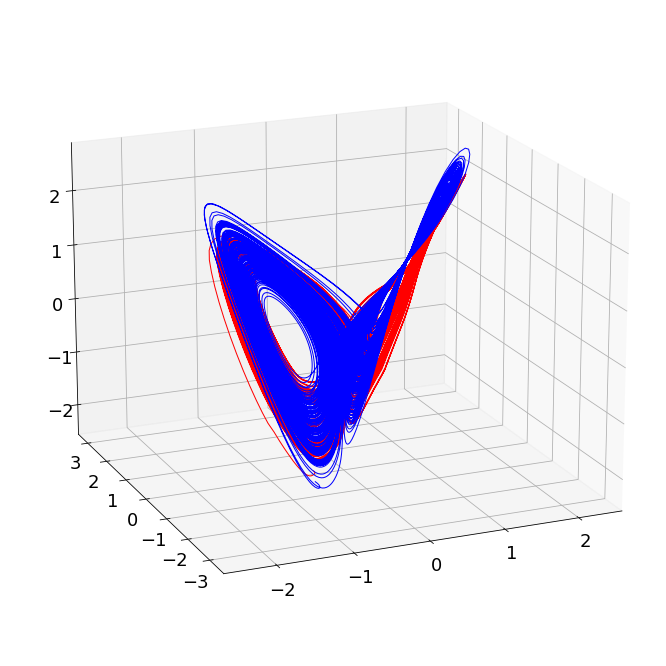

In [24]:
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})

j=19

x, y, z = ((y_pred[:,j,:]).T).detach().numpy() #*np.std(x_t,(0,1)) + np.mean(x_t,axis=(0,1))
ax.plot(x, y, z,linewidth=1, color='r')
#ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
x1, y1, z1 = (((x_t_test[j,:,:]) - np.mean(x_t_test[:,:,:],axis = (0,1)))/np.std(x_t_test[:,:,:],(0,1))[0]).T
ax.plot(x1, y1, z1,linewidth=1, color='b')
    
             
ax.view_init(18, -113)
plt.show()

In [25]:
(((x_t_test[j,:,:]) - np.mean(x_t_test[:,:,:],axis = (0,1)))/np.std(x_t_test[:,:,:],(0,1))[0]).shape

(20001, 3)